# Data preparation

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import configuration as config 

## 1. Load combined data

In [2]:
data_df=pd.read_csv(config.COMBINED_DATAFILE)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628615 entries, 0 to 628614
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   origin          628615 non-null  object 
 1   destination     628615 non-null  object 
 2   departure_time  628615 non-null  float64
 3   tail_number     628615 non-null  object 
 4   incident        628615 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 24.0+ MB


## 2. Combine origin/destination to 'route'
### 2.1. Data visualization 

In [3]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    MSN         DTW          1623.0      N909XJ         0
1    CLT         LGA          1828.0      N195PQ         0
2    CLT         LGA          1731.0      N166PQ         0
3    CLT         LGA          1731.0      N341PQ         0
4    CLT         LGA          1732.0      N147PQ         0


In [4]:
airport_features=['origin','destination']

print('Unique levels by feature')
data_df[airport_features].nunique()

Unique levels by feature


origin         5895
destination    5918
dtype: int64

In [5]:
print(data_df['origin'].value_counts().head(15))

origin
ATL    28046
ORD    25742
DFW    25318
DEN    25170
CLT    20271
PHX    16970
LAX    16044
LAS    15977
SEA    14061
IAH    13999
LGA    13363
MCO    12648
SFO    12299
BOS    11853
DCA    11787
Name: count, dtype: int64


In [6]:
print(data_df['destination'].value_counts().head(15))

destination
ATL    28032
ORD    25750
DFW    25308
DEN    25158
CLT    20261
PHX    16976
LAX    16044
LAS    15977
SEA    14061
IAH    13989
LGA    13364
MCO    12648
SFO    12296
BOS    11855
DCA    11789
Name: count, dtype: int64


### 2.2. Origin Airport 

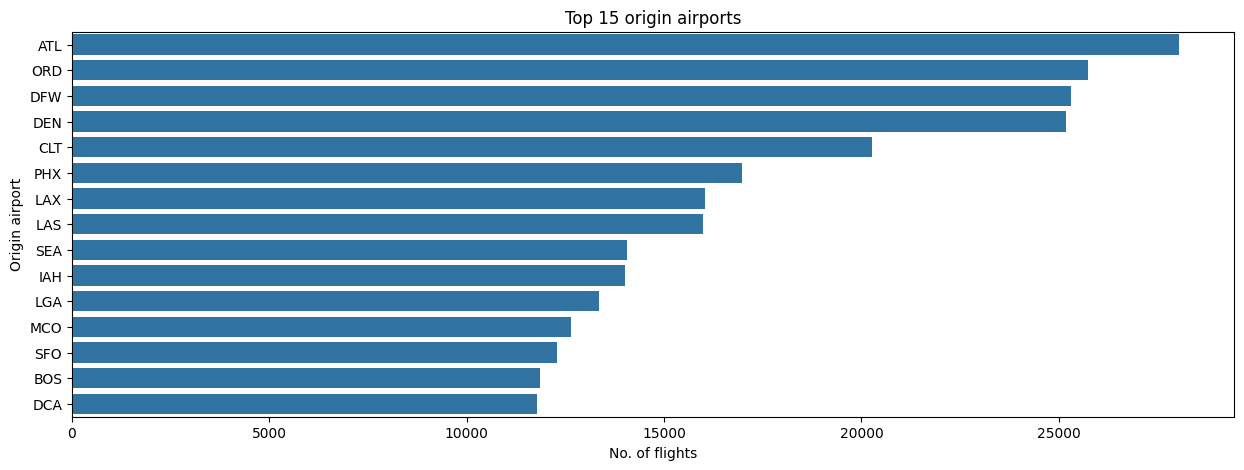

In [7]:
# Plot origin airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['origin'].value_counts().head(15).index
sns.countplot(data=data_df, y='origin', order=level_counts)

plt.title('Top 15 origin airports')
plt.xlabel('No. of flights')
plt.ylabel('Origin airport');
plt.show()

### 2.3. Destination Airport 

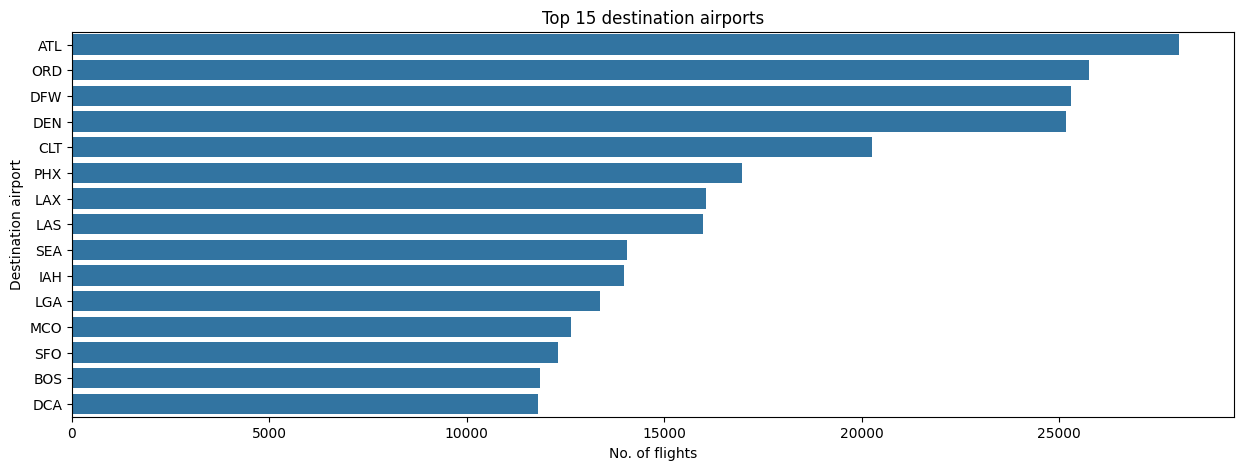

In [8]:
# Plot destination airport level counts
plt.figure(figsize=(15, 5))
level_counts=data_df['destination'].value_counts().head(15).index
sns.countplot(data=data_df, y='destination', order=level_counts)

plt.title('Top 15 destination airports')
plt.xlabel('No. of flights')
plt.ylabel('Destination airport');
plt.show()

### 2.4. Incident Feature 

In [9]:
data_df['incident'].value_counts()

incident
0    614202
1     14413
Name: count, dtype: int64

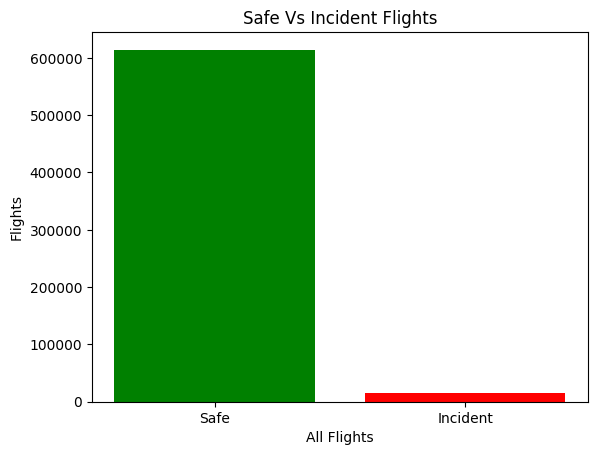

In [10]:
level_counts=data_df['incident'].value_counts()
new_labels = ['Safe', 'Incident']
plt.bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color=('green', 'red'))
plt.title('Safe Vs Incident Flights')
plt.xlabel('All Flights')
plt.xticks(range(len(level_counts)), new_labels)
plt.ylabel('Flights')
plt.show()


In [11]:
print(data_df.head())

  origin destination  departure_time tail_number  incident
0    MSN         DTW          1623.0      N909XJ         0
1    CLT         LGA          1828.0      N195PQ         0
2    CLT         LGA          1731.0      N166PQ         0
3    CLT         LGA          1731.0      N341PQ         0
4    CLT         LGA          1732.0      N147PQ         0


### 2.5. Route Feature 

In [12]:
data_df['route'] = data_df['origin'] + '_' + data_df['destination']

print(data_df.head())

  origin destination  departure_time tail_number  incident    route
0    MSN         DTW          1623.0      N909XJ         0  MSN_DTW
1    CLT         LGA          1828.0      N195PQ         0  CLT_LGA
2    CLT         LGA          1731.0      N166PQ         0  CLT_LGA
3    CLT         LGA          1731.0      N341PQ         0  CLT_LGA
4    CLT         LGA          1732.0      N147PQ         0  CLT_LGA


## 3. Encode departure time

In [13]:
cyclical_encoded_data_df = data_df.copy()

cyclical_encoded_data_df.head().T

,0,1,2,3,4
origin,MSN,CLT,CLT,CLT,CLT
destination,DTW,LGA,LGA,LGA,LGA
departure_time,1623.0,1828.0,1731.0,1731.0,1732.0
tail_number,N909XJ,N195PQ,N166PQ,N341PQ,N147PQ
incident,0,0,0,0,0
route,MSN_DTW,CLT_LGA,CLT_LGA,CLT_LGA,CLT_LGA


In [14]:
# Function to convert HHMM format to minutes since midnight
def hhmm_to_minutes(hhmm):
    hhmm_int = int(hhmm)
    hours = hhmm // 100
    minutes = hhmm % 100
    return hours * 60 + minutes

# Add minutes since midnight column
cyclical_encoded_data_df['Time'] = cyclical_encoded_data_df['departure_time'].apply(hhmm_to_minutes)

# Add formatted time label for display
cyclical_encoded_data_df['time_label'] = cyclical_encoded_data_df['departure_time'].apply(lambda x: f"{int(x)//100:02d}:{int(x)%100:02d}")

# Apply cyclical encoding - add two new columns
cyclical_encoded_data_df['time_sin'] = np.sin(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)  # 1440 minutes in a day
cyclical_encoded_data_df['time_cos'] = np.cos(2 * np.pi * cyclical_encoded_data_df['Time'] / 1440)

# Display the DataFrame with the new cyclical encoding columns
print("DataFrame with cyclical time encoding:")
print(cyclical_encoded_data_df.head(3).round(4).T)


DataFrame with cyclical time encoding:
                      0        1        2
origin              MSN      CLT      CLT
destination         DTW      LGA      LGA
departure_time   1623.0   1828.0   1731.0
tail_number      N909XJ   N195PQ   N166PQ
incident              0        0        0
route           MSN_DTW  CLT_LGA  CLT_LGA
Time              983.0   1108.0   1051.0
time_label        16:23    18:28    17:31
time_sin        -0.9118  -0.9925   -0.992
time_cos        -0.4107   0.1219  -0.1262


### 3.1. Visualization of cyclical encoding 
#### 3.1.1. Sine and cosine vale plot 

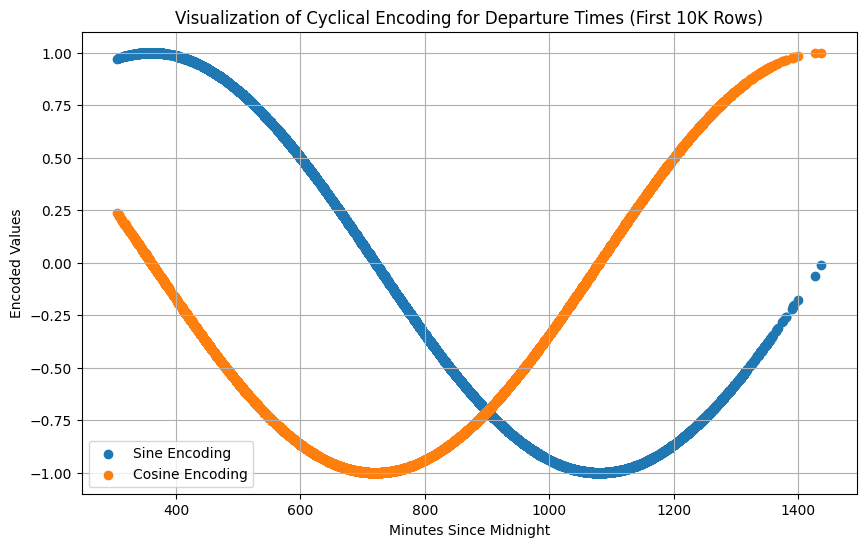

In [15]:
# Filter the DataFrame to only include the first 10K flights
filtered_data = cyclical_encoded_data_df.head(10000)

# Visualization of cyclical encoding
plt.figure(figsize=(10, 6))

# Plot sine and cosine values
plt.scatter(filtered_data['Time'], filtered_data['time_sin'], label='Sine Encoding', marker='o')
plt.scatter(filtered_data['Time'], filtered_data['time_cos'], label='Cosine Encoding', marker='o')

# Add labels, title, and legend
plt.title("Visualization of Cyclical Encoding for Departure Times (First 10K Rows)")
plt.xlabel("Minutes Since Midnight")
plt.ylabel("Encoded Values")
plt.legend()
plt.grid()
plt.show()

#### 3.1.2. Circular Visualization 

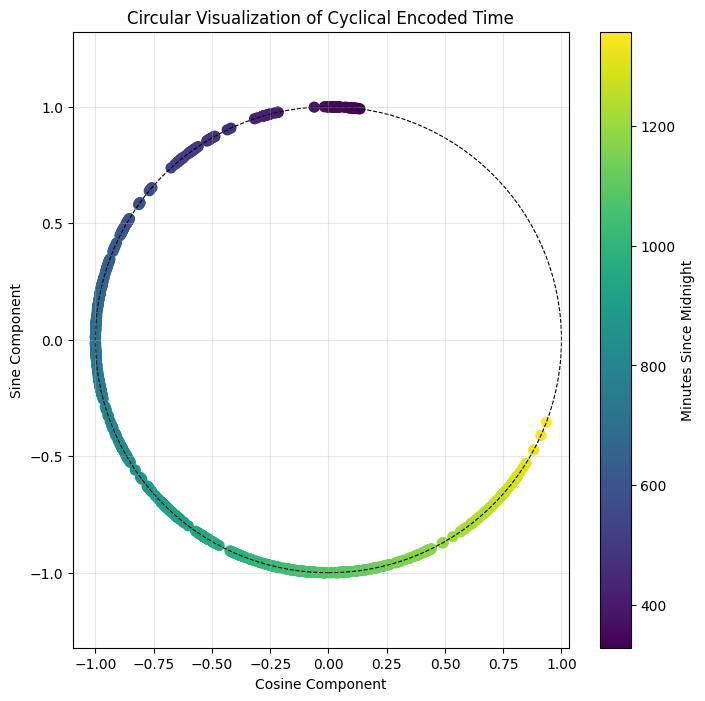

In [16]:
# Filter the DataFrame to only include the first 1000 flights
filtered_data = cyclical_encoded_data_df.head(1000)

# Circular Visualization
plt.figure(figsize=(8, 8))

# Plot the circular points
plt.scatter(filtered_data['time_cos'], filtered_data['time_sin'], c=filtered_data['Time'], cmap='viridis', s=50)

# # Add labels for each time point
# for i in range(filtered_data.shape[0]):
#     plt.text(filtered_data['time_cos'].iloc[i] * 1.2,  # Adjust position slightly outside the circle
#              filtered_data['time_sin'].iloc[i] * 1.2,
#              filtered_data['time_label'].iloc[i],
#              fontsize=9, ha='center', va='center')

# Plot a circle for reference
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=0.8)
plt.gca().add_artist(circle)

# Set aspect ratio and labels
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title("Circular Visualization of Cyclical Encoded Time")
plt.xlabel("Cosine Component")
plt.ylabel("Sine Component")
plt.grid(alpha=0.3)
plt.colorbar(label="Minutes Since Midnight")
plt.show()

## 4. Clean up features

In [17]:
cyclical_encoded_data_df.head(5)

,origin,destination,departure_time,tail_number,incident,route,Time,time_label,time_sin,time_cos
0,MSN,DTW,1623.0,N909XJ,0,MSN_DTW,983.0,16:23,-0.911762,-0.410719
1,CLT,LGA,1828.0,N195PQ,0,CLT_LGA,1108.0,18:28,-0.992546,0.121869
2,CLT,LGA,1731.0,N166PQ,0,CLT_LGA,1051.0,17:31,-0.992005,-0.126199
3,CLT,LGA,1731.0,N341PQ,0,CLT_LGA,1051.0,17:31,-0.992005,-0.126199
4,CLT,LGA,1732.0,N147PQ,0,CLT_LGA,1052.0,17:32,-0.992546,-0.121869


In [18]:
cyclical_encoded_data_df.drop(columns=['origin','destination','departure_time','tail_number','Time', 'time_label'], inplace=True)
cyclical_encoded_data_df.head(5)

,incident,route,time_sin,time_cos
0,0,MSN_DTW,-0.911762,-0.410719
1,0,CLT_LGA,-0.992546,0.121869
2,0,CLT_LGA,-0.992005,-0.126199
3,0,CLT_LGA,-0.992005,-0.126199
4,0,CLT_LGA,-0.992546,-0.121869


## 5. Encode Route 

In [19]:
# Frequency encoding for 'route'
route_frequency = cyclical_encoded_data_df['route'].value_counts()
cyclical_encoded_data_df['route_encoded'] = cyclical_encoded_data_df['route'].map(route_frequency)
cyclical_encoded_data_df.drop(columns=['route'], inplace=True)

# Display the updated dataset
print("DataFrame with frequency-encoded features:")
print(cyclical_encoded_data_df.head(5).T)

DataFrame with frequency-encoded features:
                        0           1           2           3           4
incident         0.000000    0.000000    0.000000    0.000000    0.000000
time_sin        -0.911762   -0.992546   -0.992005   -0.992005   -0.992546
time_cos        -0.410719    0.121869   -0.126199   -0.126199   -0.121869
route_encoded  108.000000  525.000000  525.000000  525.000000  525.000000


In [20]:
data_df=cyclical_encoded_data_df.copy()
data_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.911762,-0.992546,-0.992005,-0.992005,-0.992546
time_cos,-0.410719,0.121869,-0.126199,-0.126199,-0.121869
route_encoded,108.000000,525.000000,525.000000,525.000000,525.000000


## 6. Train-Test split

In [21]:
train_df, test_df=train_test_split(
    data_df,
    test_size=0.25, 
    random_state=315
)

In [22]:
train_df.head(5).T

,197559,38116,283050,141627,121789
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.551937,-0.605294,0.997859,-0.806445,-0.878817
time_cos,-0.833886,0.796002,0.065403,-0.591310,-0.477159
route_encoded,356.000000,212.000000,595.000000,58.000000,421.000000


In [23]:
train_df.reset_index(drop=True, inplace=True)
train_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.551937,-0.605294,0.997859,-0.806445,-0.878817
time_cos,-0.833886,0.796002,0.065403,-0.591310,-0.477159
route_encoded,356.000000,212.000000,595.000000,58.000000,421.000000


In [24]:
test_df.reset_index(drop=True, inplace=True)
test_df.head(5).T

,0,1,2,3,4
incident,0.000000,0.000000,0.000000,0.000000,0.000000
time_sin,-0.918791,-0.887011,-0.203642,0.250380,-0.422618
time_cos,-0.394744,0.461749,-0.979045,-0.968148,-0.906308
route_encoded,127.000000,358.000000,223.000000,118.000000,219.000000


## 7. Save

In [25]:
Path(config.PROCESSED_DATA_DIRECTORY).mkdir(exist_ok=True)

data_df.to_csv(config.ENCODED_DATAFILE)
train_df.to_csv(config.TRAINING_DATAFILE)
test_df.to_csv(config.TESTING_DATAFILE)